In [0]:
import os

import cv2

import numpy as np

import matplotlib.pyplot as plt

from keras.utils import np_utils

import pandas as pd


from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

# Import tensorflow as the backend for Keras

from keras import backend as K

K.set_image_dim_ordering('tf')

from keras.utils import np_utils

from keras.models import Sequential

from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import SGD,RMSprop,adam

from keras.callbacks import TensorBoard

# Import required libraries for cnfusion matrix

from sklearn.metrics import classification_report,confusion_matrix

import itertools
import os
from tqdm import tqdm_notebook, tnrange
from tqdm import tqdm
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa


import glob 

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [84]:
!git clone https://www.github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 914 (delta 0), reused 0 (delta 0), pack-reused 913
Receiving objects: 100% (914/914), 125.53 MiB | 28.71 MiB/s, done.
Resolving deltas: 100% (525/525), done.


In [114]:
!apt install Mask_RCNN

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package Mask_RCNN


In [0]:
sys.path.append('/content/Mask_RCNN/')

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [0]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5


In [0]:
COCO_WEIGHTS_PATH = "/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/seg_要用的/mask_rcnn_coco.h5"

In [0]:
add=os.listdir("/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/seg_要用的/correct/original/");
train_dicom_dir='/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/seg_要用的/correct/original/'
path1='/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/seg_要用的/correct/mask/'

In [0]:
debug = False

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'airbus'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 9
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background and ship classes
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES = (8, 16, 32, 64)
    TRAIN_ROIS_PER_IMAGE = 64
    MAX_GT_INSTANCES = 14
    DETECTION_MAX_INSTANCES = 10
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.0

    STEPS_PER_EPOCH = 15 if debug else 150
    VALIDATION_STEPS = 10 if debug else 125
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }
config = DetectorConfig()

In [0]:
for i in range(0,len(add)):
    add[i]=add[i].replace('.JPG','')
    add[i]=add[i].replace('.jpg','')
  


In [0]:
image_fps_train, image_fps_val = train_test_split(train_names, test_size=0.1, random_state=42)

In [0]:
if debug:
    image_fps_train = image_fps_train[:100]
    image_fps_val = image_fps_val[:100]
    test_names = test_names[:100]
    

In [0]:
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)

In [0]:
im_height=im_width=256
im_chan=3
X_train = np.zeros((len(add), im_height, im_width, im_chan), dtype=np.float)
Y_train = np.zeros((len(add), im_height, im_width, 1), dtype=np.bool)

In [0]:
for n, id_ in tqdm(enumerate(add), total=len(add)):
    path = add_
    try:
      img = load_img(path  + id_+'.JPG')
    except Exception:
      img = load_img(path  + id_+'.jpg')
    
    x = img_to_array(img)[:,:,:im_chan]
    x = resize(x, (256, 256,3), mode='constant', preserve_range=True)
    X_train[n] = x
    try:
      mask = img_to_array(load_img(path1  + id_+'.JPG'))[:,:,1]
    except Exception:
      mask = img_to_array(load_img(path1  + id_+'.jpg'))[:,:,1]
    Y_train[n] = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)

print('Done!')
    

In [0]:
ROOT_DIR='/content/gdrive/My Drive/temp'
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])
LEARNING_RATE = 0.003
model.train(X_train, Y_train,
            #validation_split=0.2,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads'
          )
    

In [0]:
try:
  a=cv2.imdecode(np.fromfile('/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/seg_要用的/mask/'+add[10]+'.jpg', dtype=np.uint8),-1)
except Exception:
  a=cv2.imdecode(np.fromfile('/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/seg_要用的/mask/'+add[10]+'.JPG', dtype=np.uint8),-1)

In [0]:
from skimage.morphology import binary_opening, disk, label
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(250, 250)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    img = np.ones((shape[0],shape[1]), dtype=np.uint8)
    for i,j in zip(starts, lengths):
      img[i,j] = 0
    
    
    return img.reshape(shape)  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((250, 250), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [0]:
starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

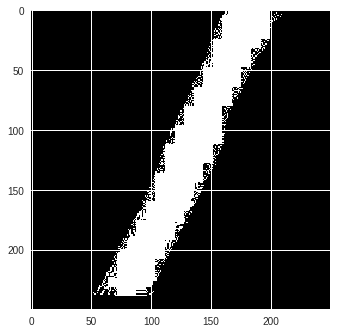

In [266]:
shape=[250, 250]
plt.imshow(b)

In [0]:
starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to alig

In [0]:
pixels = a.T.flatten()
pixels = np.concatenate([[0], pixels, [0]])
runs = np.where(pixels[1:] != pixels[:-1])[0] + 1

In [0]:
a=a/255
for i in range(0,150):



In [0]:
a=cv2.imdecode(np.fromfile('/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/seg_要用的/correct/mask/'+add[1], dtype=np.uint8),-1)

In [48]:
add[1]

'fault17.jpg'

In [0]:
a=a/255

In [38]:
nnn.shape

(2, 9079)

In [0]:
nnn=np.array(np.where(a[:,:,0]==1))

In [33]:
nnn

array([[ 61,  62,  62, ..., 244, 244, 244],
       [139, 137, 140, ...,  30,  69,  70]])

In [0]:
temp=[]
for j in range(0,9079):
  for i in range(0,2):
    temp.append(nnn[i,j])
    


In [0]:
def rle_encode1(img):
  img=img/255
  nnn=np.array(np.where(img[:,:,0]==1))
  temp=[]
  for j in range(0,nnn.shape[1]):
    for i in range(0,2):
      temp.append(nnn[i,j])
  s1=' '.join(str(x) for x in temp)
  return s1
  
  

In [0]:
a=a/255

In [66]:
rle_encode1(a)

''

In [0]:
nnn=np.array(np.where(a[:,:,0]==1))

In [60]:
temp=[]
for j in range(0,9079):
  for i in range(0,2):
    temp.append(nnn[i,j])

IndexError: ignored

In [0]:
anns=pd.DataFrame(add)

In [0]:
anns.columns=['ImageId']


In [0]:
anns['EncodedPixels']=None

'fault17.jpg'

In [0]:
for i in tqdm(range(0,129)):
  a=cv2.imdecode(np.fromfile('/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/seg_要用的/correct/mask/'+add[i], dtype=np.uint8),-1)
  anns['EncodedPixels'][i]=rle_encode1(a)
  

In [0]:
for i in tqdm(range(0,anns.shape[0])):
  try:
    a=cv2.imdecode(np.fromfile('/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/seg_要用的/mask/'+add[i]+'.jpg', dtype=np.uint8),-1)
  except Exception:
    a=cv2.imdecode(np.fromfile('/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/seg_要用的/mask/'+add[i]+'.JPG', dtype=np.uint8),-1)
  anns['EncodedPixels'][i]=  rle_encode(a/255)

In [0]:
anns

(250, 250)

In [0]:
for j in range(0,250):
  for i in range(0,250):
    if c[i,j]==0:
      c[i,j]=1
    elif c[i,j]==1:
      c[i,j]=0
      

In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('fault', 1, 'fault')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('fault', image_id=i, path=os.path.join(train_dicom_dir, fp), 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [188]:
a=anns.iloc[1,1]
rle_decode(a)

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [262]:
anns.iloc[1,0]

'fault17.jpg'

In [0]:
train_names =add
image_fps, image_annotations = train_names, anns
image_fps_train, image_fps_val = train_test_split(train_names, test_size=0.2, random_state=42)

In [0]:
ds = imread(os.path.join(train_dicom_dir, image_fps[0])) # read  image from filepath 
_ = plt.imshow(ds)

In [180]:
ORIG_SIZE = ds.shape[0]
ORIG_SIZE

250

(250, 250, 3)
/content/gdrive/Team Drives/影像辨識專題-自己小組/圖片檔/seg_要用的/correct/original/fault114.jpg
[1]


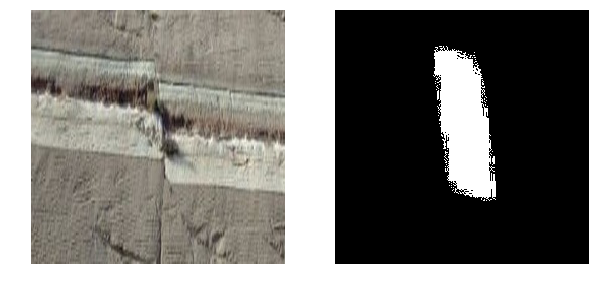

In [277]:
class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_val.image_ids)
    image_fp = dataset_val.image_reference(image_id)
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.ones(image.shape[:2])
for i in range(mask.shape[2]):
    masked -= mask[:, :, i] ## * image[:, :, 0]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [0]:
mask

In [0]:
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

In [273]:
dataset_val.image_ids

[]

In [0]:
config = DetectorConfig()

model = modellib.MaskRCNN(mode='training', config=config, model_dir='/content/gdrive/My Drive/temp')

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [302]:
LEARNING_RATE=0.001
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=4,
            layers='heads',
            augmentation=None) 


Starting at epoch 0. LR=0.002

Checkpoint Path: /content/gdrive/My Drive/temp/airbus20190114T0757/mask_rcnn_airbus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_m

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/4
150/150 [==============================] - 538s 4s/step - loss: 2.0016 - rpn_class_loss: 0.1091 - rpn_bbox_loss: 0.9750 - mrcnn_class_loss: 0.2091 - mrcnn_bbox_loss: 0.1994 - mrcnn_mask_loss: 0.5090 - val_loss: 0.9894 - val_rpn_class_loss: 0.0335 - val_rpn_bbox_loss: 0.4317 - val_mrcnn_class_loss: 0.0350 - val_mrcnn_bbox_loss: 0.0381 - val_mrcnn_mask_loss: 0.4511
Epoch 2/4
150/150 [==============================] - 387s 3s/step - loss: 0.5602 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.3851 - val_loss: 0.8142 - val_rpn_class_loss: 0.0273 - val_rpn_bbox_loss: 0.3182 - val_mrcnn_class_loss: 0.0072 - val_mrcnn_bbox_loss: 0.0296 - val_mrcnn_mask_loss: 0.4319
Epoch 3/4
150/150 [==============================] - 387s 3s/step - loss: 0.4768 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.3419 - val_loss: 0.9054 - val_rpn_class_loss

In [0]:
augmentation = iaa.Sequential()
LEARNING_RATE=0.001
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=4,
            layers='all',
            augmentation=augmentation
           )

#new_history = model.keras_model.history.history
#for k in new_history: history[k] = history[k] + new_history[k]

In [0]:
#best_epoch= np.argmin(history["val_loss"])
best_epoch= 3

In [305]:
model_path

'/content/gdrive/My Drive/temp/airbus20190114T0356/mask_rcnn_airbus_0002.h5'

In [304]:

dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))

fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in /content/gdrive/My Drive/temp/airbus20190113T0952


IndexError: ignored

In [306]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir='/content/gdrive/My Drive/temp')

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/gdrive/My Drive/temp/airbus20190114T0356/mask_rcnn_airbus_0002.h5
Re-starting from epoch 2


In [308]:
model_path='/content/gdrive/My Drive/temp/airbus20190114T0757/mask_rcnn_airbus_0004.h5'
model.load_weights(model_path, by_name=True)

Re-starting from epoch 4


In [0]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 0:
            colors.append((.941, .204, .204))
    return colors

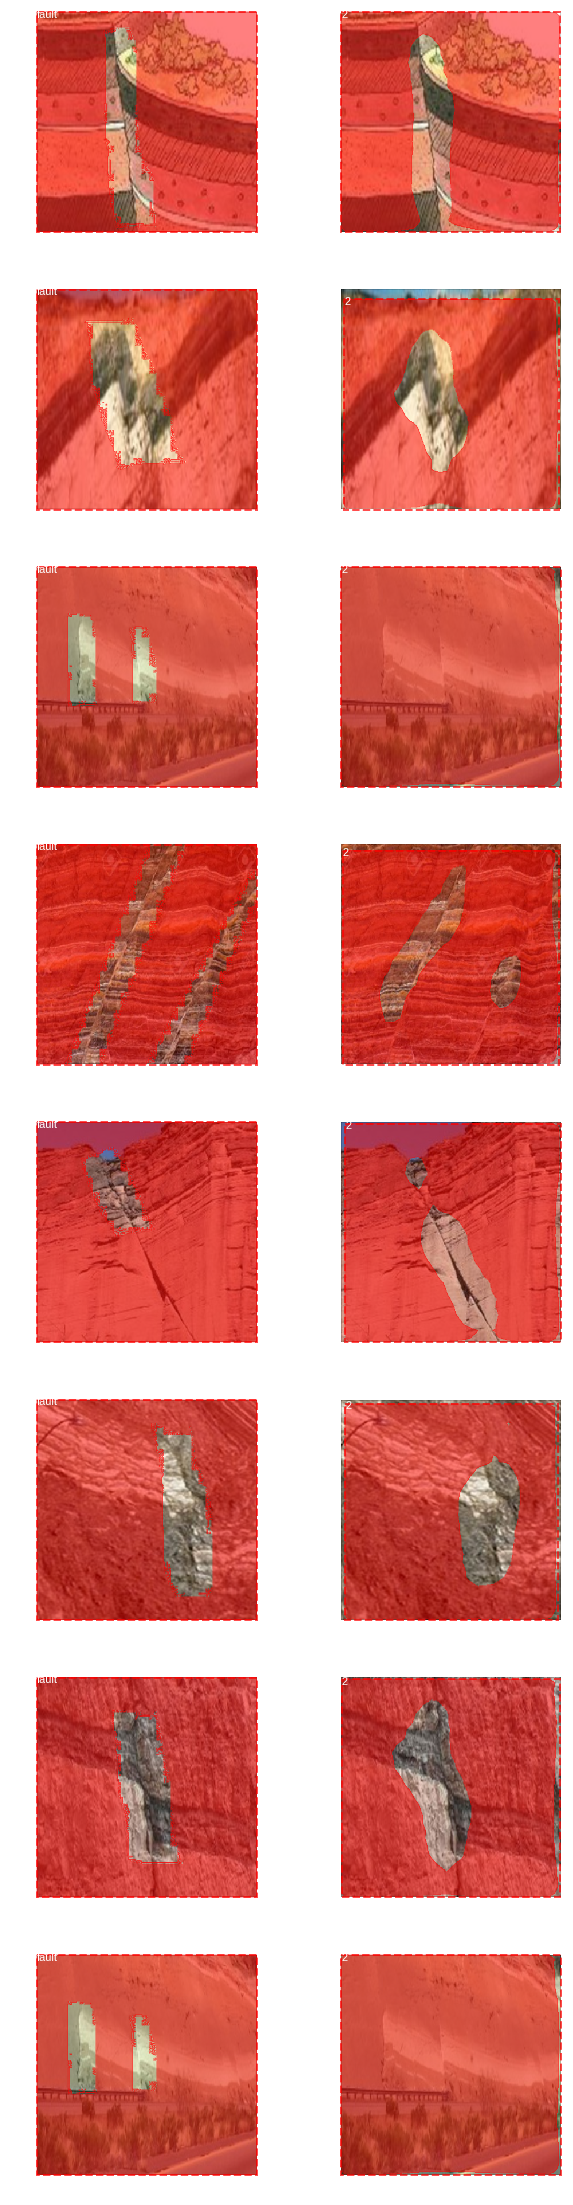

In [331]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(8):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
#     print(original_image.shape)
    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1],
                               captions='2111111111111111111111')